<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

---

**Цель:**
- Обучить модель машинного обучения для классификации комментариев на токсичные и нетоксичные.
- Достижение метрики качества — `F1 ≥ 0.75`
- Использовать `BERT` (модель на основе трансформера) для работы с текстовыми данными.

**Исходные данные:**
- Файл: `/datasets/toxic_comments.csv`
- Столбцы:
    - `text` — текст комментария.
    - `toxic` — целевой признак (`0` — нетоксичный, `1` — токсичный).

## Подготовка

In [ ]:
!pip install -q torch
!pip install -q transformers
!pip install -q catboost

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import transformers

from tqdm import notebook
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score

RANDOM_STATE = 42

In [ ]:
# Загрузка данных
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except FileNotFoundError:
    df = pd.read_csv('Модуль 4 спринт 1/toxic_comments.csv')  # Если файл локальный

**Описание данных**

Данные для выполнения проекта хранится в датасете `/datasets/toxic_comments.csv` и содержит 2 признака:

- `text` - текст комментария
- `toxic` - целевой признак (токсичные комментарии)
    -  1 (негативный комментарий)
    -  0 (негативного комментария не обнаружено)

In [ ]:
# Функция для ознакомления с таблицами
def first_chek(df, dataset_name=''):
    # Печатаем название датасета (если их несколько)
    if dataset_name:
        print(f'Анализ датасета: {dataset_name}')
    else:
        print('Анализ датасета')
    print("=" * 40 + "\n")

    print('Первые 5 строк:')
    display(df.head())
    print('\nПоледние 5 строк:')
    display(df.tail())
    print('\nРазмерность датасета:')
    print(df.shape)

    print('\nИнформаци о данных')
    print(df.info())

    print('\nОписательная статистика:')
    display(df.describe(include='all'))

In [ ]:
first_chek(df)

Анализ датасета

Первые 5 строк:


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0



Поледние 5 строк:


,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0



Размерность датасета:
(159292, 3)

Информаци о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
None

Описательная статистика:


,Unnamed: 0,text,toxic
count,159292.000000,159292,159292.000000
unique,NaN,159292,NaN
top,NaN,wow.. just deleting my comments.. Great job on...,NaN
freq,NaN,1,NaN
mean,79725.697242,NaN,0.101612
std,46028.837471,NaN,0.302139
min,0.000000,NaN,0.000000
25%,39872.750000,NaN,0.000000
50%,79721.500000,NaN,0.000000
75%,119573.250000,NaN,0.000000


Всего в датасете `df` 159292 строк и 3 столбца.

При первичном анализе пропуски в столбцах не обнаружены.

- Столбец `Unnamed: 0` это результат сохранения датасета с аргументом `index=True`. По последним столбцам можно увидеть, что индексы различаются, возможно некоторые объекты были удалены в процессе выгрузки, а значения индексов не сброшены.

In [ ]:
df['Unnamed: 0'] = range(len(df))
df.tail()

,Unnamed: 0,text,toxic
159287,159287,""":::::And for the second time of asking, when ...",0
159288,159288,You should be ashamed of yourself \n\nThat is ...,0
159289,159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159290,And it looks like it was actually you who put ...,0
159291,159291,"""\nAnd ... I really don't think you understand...",0


In [ ]:
# Удалим не нужный столбец
df = df.drop(columns='Unnamed: 0', axis=1)
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


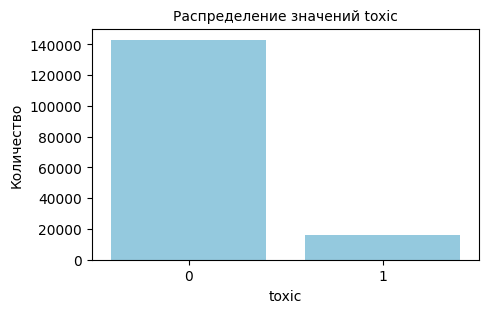

In [ ]:
plt.figure(figsize=(5, 3))
sns.countplot(x='toxic', data=df, color='skyblue')
plt.ylabel('Количество')
plt.title('Распределение значений toxic', fontsize=10)
plt.show;

In [ ]:
df['toxic'].value_counts(normalize=True) * 100

0    89.838787
1    10.161213
Name: toxic, dtype: float64

Выявлен сильный дисбаланс в целевой пременной.

Подготовим данные перед обучением.

In [ ]:
# Выбираем 15% данных для ускорения обучения
df_sample = df.sample(frac=0.15, random_state=RANDOM_STATE)

X = df_sample.drop(columns='toxic', axis=1)
y = df_sample['toxic']
X.shape

(23894, 1)

Выполним токенизацию текста.

TinyBERT - `unitary/toxic-bert` поддерживают максимальную длину входной последовательности 512 токенов. В данных есть тексты, которые после токенизации превращаются в последовательности из 905 токенов. Поэтому ограничим последовательности до 512 токенов.

In [ ]:
# инициализируем токенизатор
tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')

tokenized = df_sample['text'].apply(
    lambda x: tokenizer.encode(
        x,
        add_special_tokens=True,
        max_length=512,      # Ограничение длины
        truncation=True      # Обрезать текст, если превышает
    )
)

n = tokenized.apply(len).max()
padded = tokenized.apply(lambda x: x + [0]*(n - len(x)))
padded = np.array(padded.tolist())
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(23894, 512)

In [ ]:
config = transformers.AutoConfig.from_pretrained('unitary/toxic-bert')
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert', config=config)

batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):    # отображает прогресс-бар (работу цикла)
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])    # Тензор, количество текстов в батче и количество токенов
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)    # BERT возвращает кортеж, last_hidden_state и pooler_output

        embeddings.append(batch_embeddings[0][:,0,:].numpy())                       # выбираем last_hidden_state, для каждого 101 CLS токена в
                                                                                    # последовательности выводим его представление
# Сохраняем все эмбеддинги в одином массиве
X = np.concatenate(embeddings)

  0%|          | 0/238 [00:00<?, ?it/s]

In [ ]:
display(X.shape)
y.shape

(23800, 768)

(23894,)

После целочисленного деления привело к потере 94 строк, чтобы исправить ситуацию и не получать эмбеддинги повторно, избавимся от 94 строк в цлевой переменной.

In [ ]:
y = y[:X.shape[0]]

In [ ]:
# Используем стратификацию, чтобы сохранить пропорцию классов
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, stratify=y)

In [ ]:
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(17850, 768)

(17850,)

(5950, 768)

(5950,)

## Обучение

Для обучения моделей будем использовать пайплайн

In [ ]:
# Создадим список с названиями признаков
num_columns = slice(0, X_train.shape[1])  # Числовые признаки

In [ ]:
# Все признаки числовые (эмбеддинги BERT), поэтому применяем StandardScaler ко всем
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [ ]:
# Итоговый пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [ ]:
# Словарь с моделями и их гиперпараметрами для RandomizedSearchCV
param_grid = [
    # Словарь для модели DecisionTreeRegressor()
    {
        'model': [DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE)],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [5, 10, 15],
        'preprocessor__num': [StandardScaler(), FunctionTransformer()]
    },

    # Словарь для модели CatBoostRegressor()
    {
        'model': [CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)],
        'model__depth': [6, 8],
        'model__iterations': [100, 500],
        'model__learning_rate': [0.1, 0.15],
        'model__class_weights': [[1, 8]],
        'preprocessor__num': [StandardScaler(), FunctionTransformer()]
    },

    # Словарь для модели LinearRegression()
    {
        'model': [LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)],
        'model__C': [0.1, 1, 10],
        'model__penalty': ['l1', 'l2'],
        'model__solver': ['liblinear'],
        'preprocessor__num': [StandardScaler(), FunctionTransformer()]
    },
]

In [ ]:
random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='f1',
    n_iter=30,  # Количество случайных комбинаций
    random_state=RANDOM_STATE,
    n_jobs=-1
)
random_search.fit(X_train, y_train)

C:\Users\abdulagadzhi\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.9209752  0.91549225 0.93306277 0.92372469 0.92299153 0.91161988
 0.92158786 0.9222111  0.91452611 0.93853485 0.92372469 0.9215035
 0.93423411 0.9223181  0.93815875 0.91161988 0.94239965 0.93416836
 0.92651537        nan 0.9216647  0.92312241 0.9215035  0.92158786
 0.93745949 0.94239965 0.93416836 0.92098215 0.91464696 0.92500525]
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               slice(0, 768, None))])),
                                             ('model',
                                              DecisionTreeClassifier(random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions=[{'model': [DecisionTreeClassifier(class_weight='balanced',
                                                                          random_state=42)],
                                         'model__max_de...
                                         'model__iterations': [100, 500],
                          

In [ ]:
best_params = random_search.best_params_
print(f'Лучшие параметры модели:')
best_params

Лучшие параметры модели:


{'preprocessor__num': FunctionTransformer(),
 'model__learning_rate': 0.1,
 'model__iterations': 500,
 'model__depth': 8,
 'model__class_weights': [1, 8],
 'model': <catboost.core.CatBoostClassifier at 0x1c40ae14ee0>}

In [ ]:
best_f1 = random_search.best_score_
print(f'Метрика F1, для модели CatBoostClassifier на кросс-валидации: {best_f1:.2f}')

Метрика F1, для модели CatBoostClassifier на кросс-валидации: 0.94


Значение метрики F1 на кросс-валидации больше 0,94, что подходит под условие задачи.

In [ ]:
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred_best)
print(f'F1 на тестовой выборке для лучшей модели: {test_f1:.2f}')

F1 на тестовой выборке для лучшей модели: 0.94


## Выводы

**Выводы по проекту**
**1. Описание задачи**
- **Цель**: Разработка модели для классификации комментариев на токсичные и нетоксичные с метрикой **F1 ≥ 0.75**.
- **Бизнес-задача**: Автоматическая модерация контента в интернет-магазине **«Викишоп»**.
- **Данные**:
  - Датасет: `toxic_comments.csv`.
  - Признаки: `text` (текст комментария), `toxic` (целевой признак: 0 — нетоксичный, 1 — токсичный).
  - Размер: `159 292` комментария, дисбаланс классов (токсичные — `10.16%`, нетоксичные — `89.84%`).

**2. Подготовка данных**
- **Предобработка**:
  - Удаление столбца (`Unnamed: 0`).
- **Токенизация**:
  - Использован `AutoTokenizer` и `AutoModel` для извлечения эмбеддингов **BERT**.
  - Применена стратификация при разбиении на обучающую и тестовую выборки.
- **Эмбеддинги**:
  - Использован `[CLS]`-токен для классификации.
  - Масштабирование признаков через `StandardScaler`.

**3. Обучение моделей**
- **Модели**:
  - `DecisionTreeClassifier`, `LogisticRegression`, `CatBoostClassifier`.
- **Поиск гиперпараметров**:
  - Использован `RandomizedSearchCV` с `n_iter=30` и `cv=5`.
- **Лучшая модель**:
  - `CatBoostClassifier` с параметрами:
    ```python
    {
      'model__depth': 8,
      'model__iterations': 500,
      'model__learning_rate': 0.1,
      'preprocessor__num': FunctionTransformer(),
      'model__class_weights': [1, 8]
    }
    ```
  - **F1-метрика**:
    - На кросс-валидации: **0.94**.
    - На тестовой выборке: **0.94**.

**5. Основные выводы**
- **Лучшая модель**: `CatBoostClassifier` с эмбеддингами **BERT**.
- **Метрика F1**: `0.94` (превышает целевое значение `0.75`).
- **Ключевые факторы**:
  1. **Использование BERT**.
  2. **Взвешивание классов**: `class_weights=[1, 8]` компенсировало дисбаланс.
  3. **Стратификация**: Сохранение пропорций классов при разбиении.

**6. Рекомендации для бизнеса**
1. **Внедрение модели**:
   - Интеграция в веб-сервис для автоматической модерации.
   - Отправка токсичных комментариев на ручную проверку.
2. **Регулярное обновление модели**:
   - Дообучение на новых данных для адаптации к эволюции языка.
3. **Анализ ошибок**:
   - Изучение случаев, где модель ошибается (например, скрытый сарказм).
4. **Мониторинг пользовательского контента**:
   - Использование модели для еженедельного анализа комментариев.
   - Снижение нагрузки на модераторов за счёт автоматизации.